In [1199]:

import control as ct
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
from matplotlib.patches import FancyArrowPatch
import cvxpy as cp

In [1200]:
def calculate_ise(y_desired, y_actual, t):
  """
  Calcula o Integral of Squared Error (ISE) para os dados fornecidos.

  Parâmetros:
  y_desired (array): Vetor da saída desejada.
  y_actual (array): Vetor da saída atual do sistema.
  t (array): Vetor de tempo correspondente.

  Retorna:
  float: O valor do ISE.
  """
  # Calcular o erro
  e = y_desired - y_actual

  # Calcular o quadrado do erro
  e_squared = e ** 2

  # Calcular o ISE (Integral do quadrado do erro)
  # Usando a regra do trapézio para integração numérica
  ISE = np.trapz(e_squared, t)

  return ISE

In [1201]:
def show_matrix(name, matrix, decimal_places=2):
  """
  Apresenta uma matriz com a quantidade de casas decimais desejadas.

  Parâmetros:
  ---
  - matrix: numpy.ndarray, a matriz a ser apresentada.
  - casas_decimais: int, o número de casas decimais desejadas (padrão é 2).
  """
  pattern = "{:." + str(decimal_places) + "e}"

  def format_elem(elem):
    return pattern.format(elem)

  width = [max(map(len, map(format_elem, coluna))) for coluna in matrix.T]

  print(name, "=")

  nspaces = sum(width) + 2 * matrix.shape[1]

  print("    ┌" + " " * nspaces + "┐")
  for line in matrix:
    formatted_line = "  ".join(format_elem(e).rjust(largura)
                               for e, largura in zip(line, width))
    print("    │ " + formatted_line + " │")
  print("    └" + " " * nspaces + "┘")
  print()


def set_subplot(ax, x_data, y_data, xlabel, ylabel, title, line_color='#120a8f', linewidth=1.5):
  line, = ax.plot(x_data, y_data, linestyle='-',
                  color='black', linewidth=linewidth)
  ax.set_xlabel(xlabel, fontsize=12)
  ax.set_ylabel(ylabel, fontsize=12)
  ax.grid(linestyle='--')
  ax.set_title(title, fontsize=14)
  ax.tick_params(axis='both', direction='in', length=4, width=1,
                 colors='black', top=True, right=True, labelsize=16)

  return line

In [1202]:
from scipy.optimize import *


def find_extrema_multivar(expression, bounds, variables):
  # Ambiente seguro para avaliação da expressão, incluindo funções trigonométricas do módulo math
  environment = {k: getattr(math, k)
                 for k in dir(math) if not k.startswith("__")}

  # Definindo a função a ser minimizada
  def fun(var_values):
    local_env = {var: val for var, val in zip(variables, var_values)}
    try:
      return eval(expression, {"__builtins__": None}, {**local_env, **environment})
    except ZeroDivisionError:
      return float('inf')  # Retorna infinito se houver divisão por zero

  # Convertendo os limites do dicionário para uma lista de tuplas
  bounds_list = [bounds[var] for var in variables]

  # Definindo um ponto inicial no meio do intervalo para cada variável
  x0 = [(b[0] + b[1]) / 2 for b in bounds_list]

  # Encontrando o valor mínimo usando o método 'Powell'
  min_result = minimize(fun, x0=x0, bounds=bounds_list, method='Powell')
  if not min_result.success:
    raise ValueError("Minimization did not converge")
  min_value = min_result.fun
  min_point = min_result.x

  # Encontrando o valor máximo (minimizando o negativo da função) usando o método 'Powell'
  max_result = minimize(lambda var_values: -fun(var_values),
                        x0=x0, bounds=bounds_list, method='Powell')
  if not max_result.success:
    raise ValueError("Maximization did not converge")
  max_value = -max_result.fun
  max_point = max_result.x

  return min_value, max_value

In [1203]:
# Parameter Definition
Mass = 0.05
Jb = 2e-6
R = 0.01
g = 9.81
_B = Mass / (Mass + (Jb / (R ** 2)))

z1_min, z1_max = find_extrema_multivar(
    f'-{g} * {_B} * sin(x) / x',
    bounds={'x': (-1, 1)},
    variables=['x']
)

z2_min, z2_max = find_extrema_multivar(
    f'{_B} * x * y',
    bounds={'x': (-1, 1), 'y': (-5, 5)},
    variables=['x', 'y']
)

print(z1_min, z1_max)
print(z2_min, z2_max)

Z = [
    [z1_min, z1_max],
    [z2_min, z2_max]
]

time_simulation = 40
timepts = np.linspace(0, time_simulation, 1000)


perturbation = np.zeros_like(timepts)
start_time = 15
end_time = 17
indexes = np.where((timepts >= start_time) & (timepts <= end_time))
perturbation[indexes] = 10

# X0 = [0.3, 0, 0.4, 0.2]
X0 = [0.3, 0.2, 0.4, 0]

print('B', _B)

-7.007142857142858 -5.896409495246948
-3.571255811800926 3.571255811800926
B 0.7142857142857143


<string>:1: RuntimeWarning: invalid value encountered in scalar divide
<string>:1: RuntimeWarning: invalid value encountered in scalar divide


In [1204]:
def He(A):
  return A + A.T


def z1(x):
  return - (_B * g * math.sin(x[2])) / x[2]


def z2(x):
  return _B * x[0] * x[3]


def A(z):
  return np.array([
      [0, 1, 1, 0],
      [0, 0, z[0], z[1]],
      [0, 0, 0, 1],
      [0, 0, 0, 0]])


# Define the parameters for the optimization problem

X = cp.Variable((4, 4), name='X', PSD=True)
Y = cp.Variable((4, 4), name='Y')
M = [cp.Variable((1, 4), name='M00'),
     cp.Variable((1, 4), name='M01'),
     cp.Variable((1, 4), name='M10'),
     cp.Variable((1, 4), name='M11')]

s = 2

B2 = list(itertools.product([0, 1], repeat=2))

constraints = []
for i in B2:
  for j in B2:
    if 2 * i[0] + i[1] > 2 * j[0] + j[1]:
      continue

    zi = []
    for idx, b in enumerate(i):
      zi.append(Z[idx][b])

    zj = []
    for idx, b in enumerate(j):
      zj.append(Z[idx][b])

    Ai = A(zi)
    Aj = A(zj)
    Bi = Bj = np.array([[0], [0], [0], [1]])
    Mi = M[2 * i[0] + i[1]]
    Mj = M[2 * j[0] + j[1]]

    if i == j:
      constraints += [He(Ai @ X) - He(Bi @ Mi) + (s-1) * Y << 0]
    else:
      constraints += [-2 * Y + He(Ai @ X + Aj @ X - Bi @ Mj - Bj @ Mi) <= 0]

constraints += [Y >= 0]

# Define the objective function and constraints
obj = cp.Maximize(0)

# Define the optimization problem
prob = cp.Problem(obj, constraints)

# Solve the problem using the MOSEK solver
prob.solve(solver=cp.MOSEK, verbose=False)

# Initialize variables to store results
K = None

# Display the results
if prob.status not in ["infeasible", "unbounded"]:
  print("Optimal value: %s\n" % prob.value)
  # for variable in prob.variables():
  #   if len(variable.shape) == 2:
  #     show_matrix(variable.name(), variable.value)
  #   else:
  #     print(variable.name(), '=', variable.value, '\n')

  # Compute the inverse of X and use it to calculate Ξ and K
  X_INV = np.linalg.inv(X.value)
  # Q = X_INV @ Y.value @ X_INV

  # show_matrix('P', X_INV)
  # show_matrix('Q', Q)

  for i in range(0, 4):
    show_matrix(f'K[{i}]', M[i].value @ X_INV)

  K1 = M[0].value @ X_INV
  K2 = M[1].value @ X_INV
  K3 = M[2].value @ X_INV
  K4 = M[3].value @ X_INV
  K = [[K1, K2], [K3, K4]]


else:
  print('The problem is not feasible')

Optimal value: 0.0

K[0] =
    ┌                                          ┐
    │ -1.96e+01  -4.59e+01  2.16e+02  7.02e+00 │
    └                                          ┘

K[1] =
    ┌                                          ┐
    │ -2.92e+00  -2.21e+00  5.61e+01  2.09e+00 │
    └                                          ┘

K[2] =
    ┌                                          ┐
    │ -1.97e+01  -4.62e+01  2.17e+02  7.05e+00 │
    └                                          ┘

K[3] =
    ┌                                          ┐
    │ -3.02e+00  -2.47e+00  5.71e+01  2.12e+00 │
    └                                          ┘



In [1205]:
def ball_beam_update(t, x, u, params):
  u = np.array([[u[0]]])
  x = np.array([[x[0]], [x[1]], [x[2]], [x[3]]])

  if x[2] == 0:
    return x

  x_dot = 0

  zt = [z1(x), z2(x)]

  _M = []
  for i in range(0, 2):
    m = (zt[i] - Z[i][0]) / (Z[i][1] - Z[i][0])
    _M.append([1. - m, m])

  B2 = list(itertools.product([0, 1], repeat=2))

  for p in B2:
    σp = 1.
    f = []
    for i, b in enumerate(p):
      σp *= _M[i][b]
      f.append(Z[i][b])

    Ap = A(f)
    Bp = np.array([[0], [0], [0], [1]])

    x_dot += σp * (Ap @ x + Bp @ u)

  return x_dot


ball_beam_system = ct.ss(
    ball_beam_update, None, name='ball_beam_system',
    inputs=('u'),
    outputs=('x1', 'x2', 'x3', 'x4'),
    states=('x1', 'x2', 'x3', 'x4'))

In [1206]:
def controller_output(time, state, input, params):
  x = np.array([[input[0]], [input[1]], [input[2]], [input[3]]])

  if x[2] == 0:
    return 0

  zt = [z1(x), z2(x)]

  _M = []
  for i in range(0, 2):
    m = (zt[i] - Z[i][0]) / (Z[i][1] - Z[i][0])
    _M.append([1. - m, m])

  u = 0
  B2 = list(itertools.product([0, 1], repeat=2))

  for p in B2:
    σp = 1.
    for i, b in enumerate(p):
      σp *= _M[i][b]

    Kp = K[p[0]][p[1]]
    u += σp * Kp @ x

  return -u


controller = ct.ss(None, controller_output, name="controller",
                   inputs=('x1', 'x2', 'x3', 'x4'),
                   states=None,
                   output=('u'))

In [1207]:
closed_loop_system = ct.interconnect(
    (ball_beam_system, controller),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('ball_beam_system.u', 'controller.u'),

        # Conexão da saída do ZOH no controllerador
        ('controller.x1', 'ball_beam_system.x1'),
        ('controller.x2', 'ball_beam_system.x2'),
        ('controller.x3', 'ball_beam_system.x3'),
        ('controller.x4', 'ball_beam_system.x4'),
    ),
    name='closed-loop system',
    inplist=('ball_beam_system.u'),
    outlist=('ball_beam_system.x1',
             'ball_beam_system.x2',
             'ball_beam_system.x3',
             'ball_beam_system.x4',
             'controller.u',
             ),
    output=('x1', 'x2', 'x3', 'x4', 'u')
)

In [1208]:
t, y = ct.input_output_response(
    sys=closed_loop_system, T=timepts,
    X0=X0,
    U=perturbation
)

/tmp/ipykernel_124207/202759288.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return - (_B * g * math.sin(x[2])) / x[2]


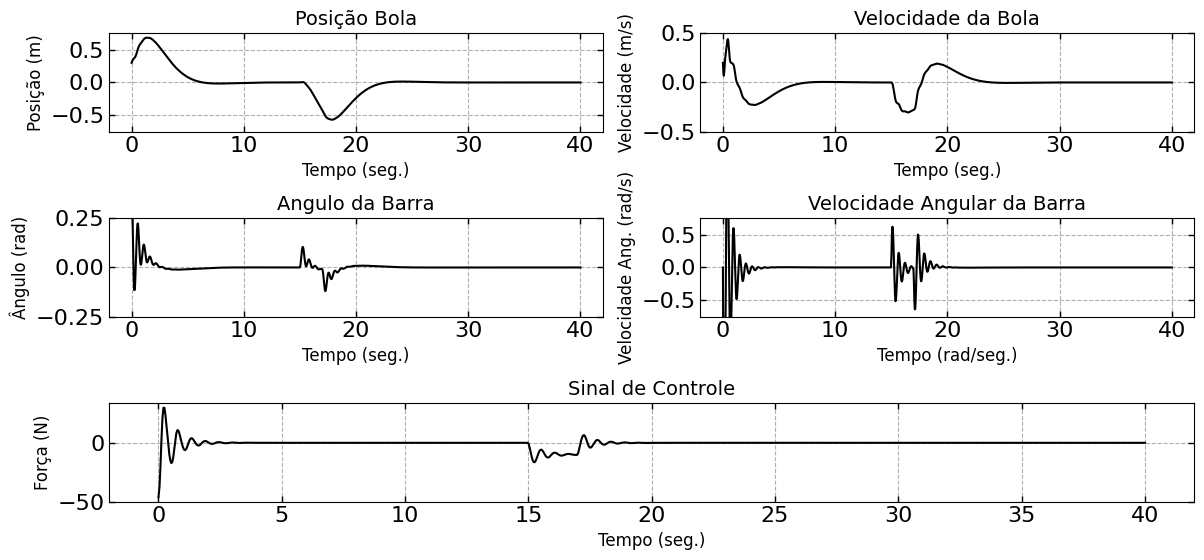

In [1209]:
import matplotlib.pyplot as plt

# Definindo o tamanho da figura
fig = plt.figure(figsize=(12, 6))

# Usando subplot2grid para configurar os subplots
ax1 = plt.subplot2grid((3, 2), (0, 0))
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax3 = plt.subplot2grid((3, 2), (1, 0))
ax4 = plt.subplot2grid((3, 2), (1, 1))
# Este subplot ocupa duas colunas
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)

# Definindo limites de y para os subplots desejados
ax1.set_ylim(-0.75, 0.75)
ax2.set_ylim(-0.5, 0.5)
ax3.set_ylim(-0.25, 0.25)
ax4.set_ylim(-.75, .75)

# Configurando os subplots usando a função set_subplot
set_subplot(ax1, t, y[0], 'Tempo (seg.)', 'Posição (m)', 'Posição Bola')
set_subplot(ax2, t, y[1], 'Tempo (seg.)',
            'Velocidade (m/s)', 'Velocidade da Bola')
set_subplot(ax3, t, y[2], 'Tempo (seg.)',
            'Ângulo (rad)', 'Angulo da Barra')
set_subplot(ax4, t, y[3], 'Tempo (rad/seg.)',
            'Velocidade Ang. (rad/s)', 'Velocidade Angular da Barra')
set_subplot(ax5, t, y[4], 'Tempo (seg.)',
            'Força (N)', 'Sinal de Controle')

# Ajustando o espaço para o título
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('/home/andel/Documentos/Mestrado/Disciplinas/Sistemas Inteligentes/Trabalho 1/Relatório/figures/sim2.eps', format='eps')

In [1210]:
calculate_ise(np.zeros_like(0), y[0], t)

1.8740847016173678

In [1211]:
def gauss(x, x0):
  return math.exp((x - x0) ** 2 / (2 * (0.2) ** 2))

In [1212]:
A = [
    np.array([
        [0, 1.00, 0, 0],
        [0, 0, -7.007, 0.000],
        [0, 0, 0, 1],
        [0, 0, 0, 0]]),
    np.array([
        [0, 1, 0, 0],
        [0, 0, -6.821, 0.042],
        [0, 0, 0, 1],
        [0, 0, 0, 0]]),
    np.array([
        [0, 1, 0, 0],
        [0, 0, -6.594, 0.142],
        [0, 0, 0, 1],
        [0, 0, 0, 0]])
]


def He(A):
  return A + A.T


def z1(x):
  _B = Mass / (Mass + (Jb / (R ** 2)))
  return - (_B * g * math.sin(x[2])) / x[2]


def z2(x):
  _B = Mass / (Mass + (Jb / (R ** 2)))
  return _B * x[0] * x[3]


# Define the parameters for the optimization problem

X = cp.Variable((4, 4), name='X', PSD=True)
Y = cp.Variable((4, 4), name='Y')
M = [cp.Variable((1, 4), name='M00'),
     cp.Variable((1, 4), name='M01'),
     cp.Variable((1, 4), name='M10')]

zt = [z1, z2]
B = np.array([[0], [0], [0], [1]])
Ai = np.array((2, 2))
s = 2

B2 = list(itertools.product([0, 1], repeat=2))

constraints = []
for i in range(0, 3):
  for j in range(0, 3):
    if i > j:
      continue

    Ai = A[i]
    Aj = A[j]
    Bi = Bj = B
    Mi = M[i]
    Mj = M[j]

    if i == j:
      constraints += [-He(Ai @ X) + He(B @ Mi) - (s-1) * Y >> 0]
    else:
      constraints += [2 * Y - He(Ai @ X + Aj @ X - Bi @ Mj - Bj @ Mi) >> 0]

constraints += [Y >> 0]

# Define the objective function and constraints
obj = cp.Maximize(0)

# Define the optimization problem
prob = cp.Problem(obj, constraints)

# Solve the problem using the MOSEK solver
prob.solve(solver=cp.MOSEK, verbose=False)

# Initialize variables to store results
K = None

# Display the results
if prob.status not in ["infeasible", "unbounded"]:
  print("Optimal value: %s\n" % prob.value)
  # for variable in prob.variables():
  #   if len(variable.shape) == 2:
  #     show_matrix(variable.name(), variable.value)
  #   else:
  #     print(variable.name(), '=', variable.value, '\n')

  # Compute the inverse of X and use it to calculate Ξ and K
  X_INV = np.linalg.inv(X.value)
  Q = X_INV @ Y.value @ X_INV

  # _K = K_TIL @ X_INV
  # K = _K.value

  show_matrix('P', X_INV)
  show_matrix('Q', Q)

  for i in range(0, 3):
    show_matrix(f'K[{i}]', M[i].value @ X_INV)

  K1 = M[0].value @ X_INV
  K2 = M[1].value @ X_INV
  K3 = M[2].value @ X_INV
  K = [K1, K2, K3]


else:
  print('The problem is not feasible')

Optimal value: 0.0

P =
    ┌                                            ┐
    │  1.20e+00   8.32e-01  -3.33e+00  -6.39e-01 │
    │  8.32e-01   1.71e+00  -3.95e+00  -1.04e+00 │
    │ -3.33e+00  -3.95e+00   2.02e+01   3.59e+00 │
    │ -6.39e-01  -1.04e+00   3.59e+00   1.14e+00 │
    └                                            ┘

Q =
    ┌                                            ┐
    │  1.41e+00   1.68e+00  -7.88e+00  -1.47e+00 │
    │  1.65e+00   2.07e+00  -9.43e+00  -1.80e+00 │
    │ -7.96e+00  -9.66e+00   4.61e+01   8.57e+00 │
    │ -1.47e+00  -1.82e+00   8.49e+00   1.61e+00 │
    └                                            ┘

K[0] =
    ┌                                          ┐
    │ -6.13e+00  -6.47e+00  4.30e+01  7.10e+00 │
    └                                          ┘

K[1] =
    ┌                                          ┐
    │ -6.08e+00  -6.38e+00  4.28e+01  7.04e+00 │
    └                                          ┘

K[2] =
    ┌                                    

In [1213]:
def ball_beam_update(t, x, u, params):
  u = np.array([[u[0]]])
  x = np.array([[x[0]], [x[1]], [x[2]], [x[3]]])

  if x[2] == 0:
    return x

  x_dot = 0

  mu_1 = gauss(x[1], 0) * gauss(x[1], 0) * \
      gauss(x[1], 0) * gauss(x[1], 0)

  mu_2 = gauss(x[1], 0.3) * gauss(x[1], 0) * \
      gauss(x[1], 0.4) * gauss(x[1], 0.2)

  mu_3 = gauss(x[1], 0.5) * gauss(x[1], 0) * \
      gauss(x[1], 0.6) * gauss(x[1], 0.4)

  σ = [mu_1 / (mu_1 + mu_2 + mu_3),
       mu_2 / (mu_1 + mu_2 + mu_3),
       mu_3 / (mu_1 + mu_2 + mu_3)]

  for i in range(0, 3):
    Ap = A[i]
    Bp = B
    x_dot += σ[i] * (Ap @ x + Bp @ u)

  return x_dot


ball_beam_system = ct.ss(
    ball_beam_update, None, name='ball_beam_system',
    inputs=('u'),
    outputs=('x1', 'x2', 'x3', 'x4'),
    states=('x1', 'x2', 'x3', 'x4'))

In [1214]:
def controller_output(time, state, input, params):
  x = np.array([[input[0]], [input[1]], [input[2]], [input[3]]])

  if x[2] == 0:
    return 0

  mu_1 = gauss(x[1], 0) * gauss(x[1], 0) * \
      gauss(x[1], 0) * gauss(x[1], 0)

  mu_2 = gauss(x[1], 0.3) * gauss(x[1], 0) * \
      gauss(x[1], 0.4) * gauss(x[1], 0.2)

  mu_3 = gauss(x[1], 0.5) * gauss(x[1], 0) * \
      gauss(x[1], 0.6) * gauss(x[1], 0.4)

  σ = [mu_1 / (mu_1 + mu_2 + mu_3),
       mu_2 / (mu_1 + mu_2 + mu_3),
       mu_3 / (mu_1 + mu_2 + mu_3)]

  u = 0
  for i in range(0, 3):
    u += σ[i] * K[i] @ x

  return -u


controller = ct.ss(None, controller_output, name="controller",
                   inputs=('x1', 'x2', 'x3', 'x4'),
                   states=None,
                   output=('u'))

In [1215]:

closed_loop_system = ct.interconnect(
    (ball_beam_system, controller),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('ball_beam_system.u', 'controller.u'),

        # Conexão da saída do ZOH no controllerador
        ('controller.x1', 'ball_beam_system.x1'),
        ('controller.x2', 'ball_beam_system.x2'),
        ('controller.x3', 'ball_beam_system.x3'),
        ('controller.x4', 'ball_beam_system.x4'),
    ),
    name='closed-loop system',
    inplist=('ball_beam_system.u'),
    outlist=('ball_beam_system.x1',
             'ball_beam_system.x2',
             'ball_beam_system.x3',
             'ball_beam_system.x4',
             'controller.u',
             ),
    output=('x1', 'x2', 'x3', 'x4', 'u')
)

In [1216]:

t, y = ct.input_output_response(
    sys=closed_loop_system, T=timepts,
    X0=X0,
    U=perturbation
)

/tmp/ipykernel_124207/1051152975.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.exp((x - x0) ** 2 / (2 * (0.2) ** 2))


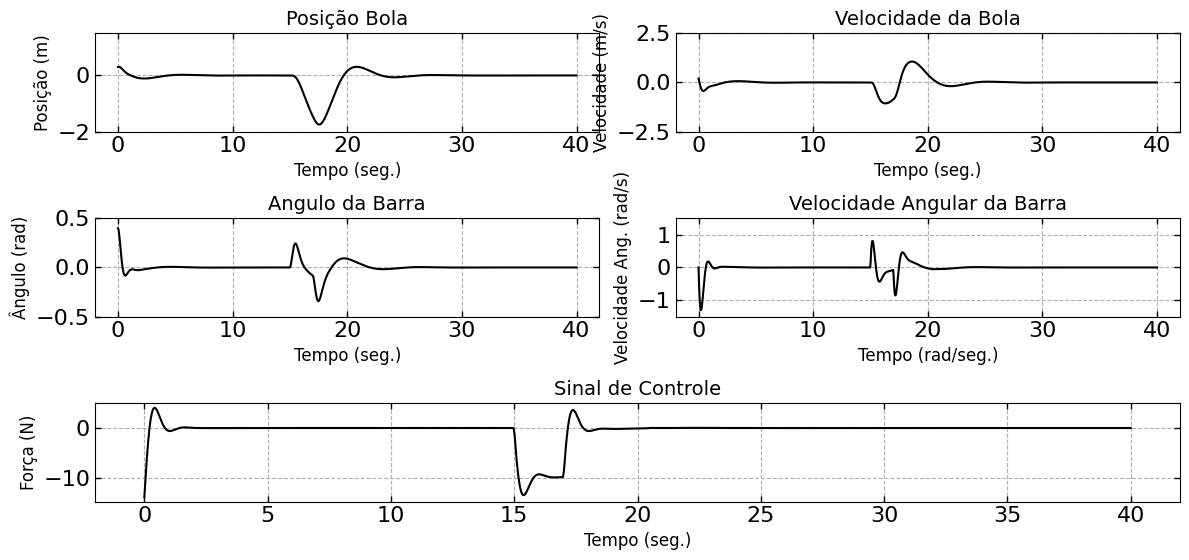

In [1217]:
import matplotlib.pyplot as plt

# Definindo o tamanho da figura
fig = plt.figure(figsize=(12, 6))

# Usando subplot2grid para configurar os subplots
ax1 = plt.subplot2grid((3, 2), (0, 0))
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax3 = plt.subplot2grid((3, 2), (1, 0))
ax4 = plt.subplot2grid((3, 2), (1, 1))
# Este subplot ocupa duas colunas
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)

# Definindo limites de y para os subplots desejados
ax1.set_ylim(-2., 1.5)
ax2.set_ylim(-2.5, 2.5)
ax3.set_ylim(-0.5, 0.5)
ax4.set_ylim(-1.5, 1.5)

# Configurando os subplots usando a função set_subplot
set_subplot(ax1, t, y[0], 'Tempo (seg.)', 'Posição (m)', 'Posição Bola')
set_subplot(ax2, t, y[1], 'Tempo (seg.)',
            'Velocidade (m/s)', 'Velocidade da Bola')
set_subplot(ax3, t, y[2], 'Tempo (seg.)',
            'Ângulo (rad)', 'Angulo da Barra')
set_subplot(ax4, t, y[3], 'Tempo (rad/seg.)',
            'Velocidade Ang. (rad/s)', 'Velocidade Angular da Barra')
set_subplot(ax5, t, y[4], 'Tempo (seg.)',
            'Força (N)', 'Sinal de Controle')

# Ajustando o espaço para o título
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('/home/andel/Documentos/Mestrado/Disciplinas/Sistemas Inteligentes/Trabalho 1/Relatório/figures/sim4.eps', format='eps')

In [1218]:
calculate_ise(np.zeros_like(0), y[0], t)

5.341489394116784